# Setup

In [10]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.footystats import GenerateDataFrame
from pipeline.X_table_constructor import XTrainConstructor, XTestConstructor

In [11]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

# Data Pre-processing

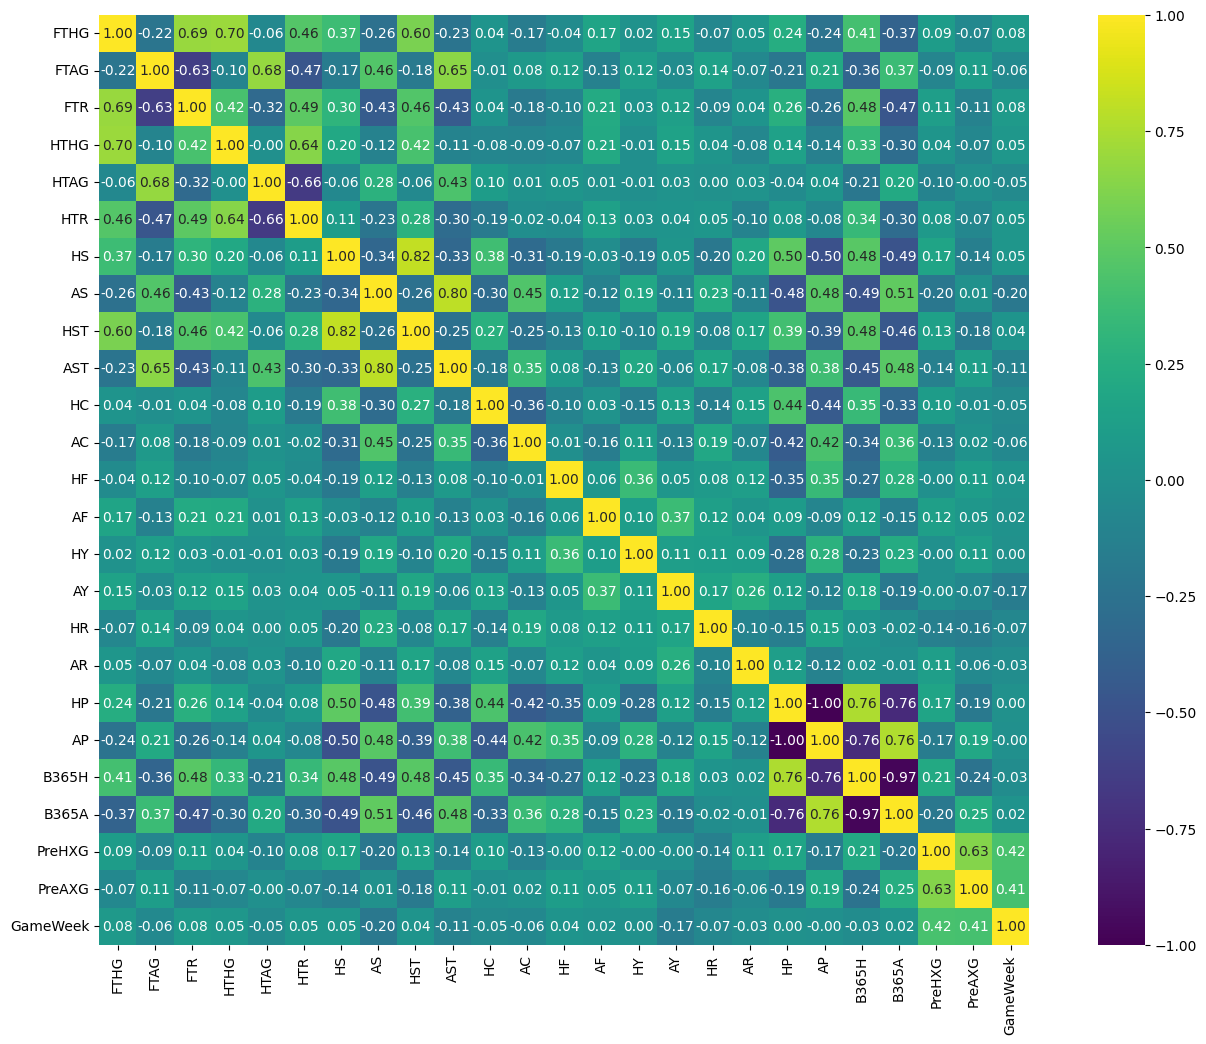

In [22]:
matrix_data = df_past1.copy()
matrix_data.drop(columns=['Date','Season', 'RoundID' ,'HomeTeam', 'AwayTeam', 'Status', 'B365D'], inplace=True)

matrix_data['FTR'] = matrix_data['FTR'].map({'H': 1, 'D': 0, 'A': -1})
matrix_data['HTR'] = matrix_data['HTR'].map({'H': 1, 'D': 0, 'A': -1})

matrix_data['B365H'] = 1 / matrix_data['B365H']
matrix_data['B365A'] = 1 / matrix_data['B365A']

scaler = StandardScaler()
matrix_data = pd.DataFrame(scaler.fit_transform(matrix_data), columns=matrix_data.columns)

corr = matrix_data.corr(method='pearson')
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
# reduce the height of the scale bar
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(top=0.77)
plt.gca().set_aspect('equal', adjustable='box')
# tight layout
plt.show()
# save fig

# FootyStats

In [26]:
df_past10

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,AP,B365H,B365D,B365A,PreHXG,PreAXG,Status,RoundID,Season,GameWeek
1140,2013-08-17 11:45:00,Liverpool,Stoke City,1,0,H,1,0,H,18,...,44,1.38,4.90,9.99,0.00,0.00,complete,22,2013/2014,1
1142,2013-08-17 14:00:00,Norwich City,Everton,2,2,D,0,0,D,2,...,67,3.27,3.44,2.33,0.00,0.00,complete,22,2013/2014,1
1143,2013-08-17 14:00:00,Sunderland,Fulham,0,1,A,0,0,D,19,...,40,2.27,3.45,3.39,0.00,0.00,complete,22,2013/2014,1
1144,2013-08-17 14:00:00,West Bromwich Albion,Southampton,0,1,A,0,0,D,8,...,50,2.29,3.49,3.31,0.00,0.00,complete,22,2013/2014,1
1145,2013-08-17 14:00:00,West Ham United,Cardiff City,2,0,H,1,0,H,11,...,54,1.94,3.63,4.26,0.00,0.00,complete,22,2013/2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,2023-12-15 20:00:00,Nottingham Forest,Tottenham Hotspur,0,2,A,0,1,A,10,...,67,3.60,3.60,1.95,1.35,1.45,complete,100543,2023/2024,17
3964,2023-12-16 15:00:00,Chelsea,Sheffield United,2,0,H,0,0,D,11,...,22,1.15,7.50,23.00,1.53,0.87,complete,100543,2023/2024,17
3966,2023-12-16 15:00:00,Manchester City,Crystal Palace,2,2,D,1,0,H,16,...,26,1.18,7.00,19.00,1.54,1.24,complete,100543,2023/2024,17
3967,2023-12-16 15:00:00,Newcastle United,Fulham,3,0,H,0,0,D,21,...,29,1.50,4.25,6.50,1.72,1.14,complete,100543,2023/2024,17


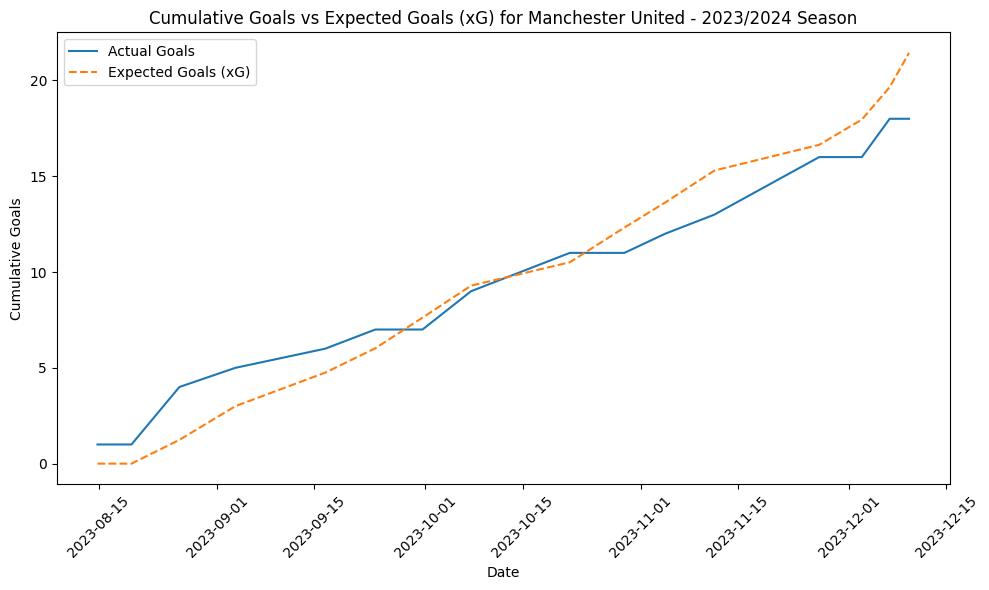

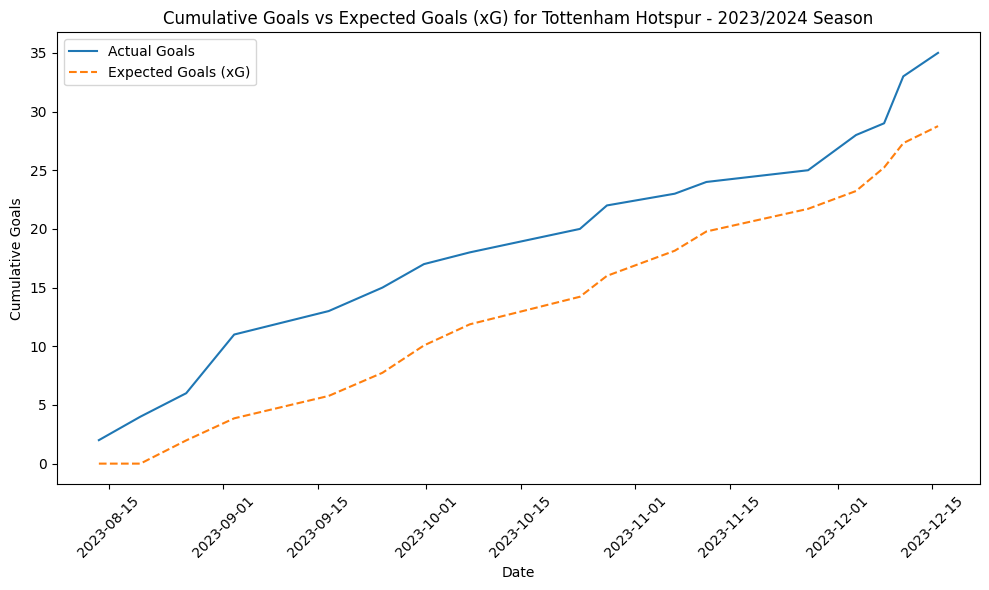

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_past10 = GenerateDataFrame(season=Season.Past10).load()

# Filter data for the season 2023/2024 and the teams Manchester United and Tottenham
filtered_df = df_past10[(df_past10['Season'] == '2023/2024') & 
                        (df_past10['HomeTeam'].isin(['Manchester United', 'Tottenham Hotspur']) | 
                         df_past10['AwayTeam'].isin(['Manchester United', 'Tottenham Hotspur']))]

# Create a plot for each team
teams = ['Manchester United', 'Tottenham Hotspur']

for team in teams:
    team_home = filtered_df[filtered_df['HomeTeam'] == team]
    team_away = filtered_df[filtered_df['AwayTeam'] == team]

    # Combine home and away data
    team_df = pd.concat([
        team_home[['Date', 'FTHG', 'PreHXG']].rename(columns={'FTHG': 'Goals', 'PreHXG': 'xG'}),
        team_away[['Date', 'FTAG', 'PreAXG']].rename(columns={'FTAG': 'Goals', 'PreAXG': 'xG'})
    ]).sort_values(by='Date')

    # Cumulative sum for game-by-game analysis
    team_df['CumulativeGoals'] = team_df['Goals'].cumsum()
    team_df['CumulativeXG'] = team_df['xG'].cumsum()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(team_df['Date'], team_df['CumulativeGoals'], label='Actual Goals')
    plt.plot(team_df['Date'], team_df['CumulativeXG'], linestyle='--', label='Expected Goals (xG)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Goals')
    plt.title(f'Cumulative Goals vs Expected Goals (xG) for {team} - 2023/2024 Season')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


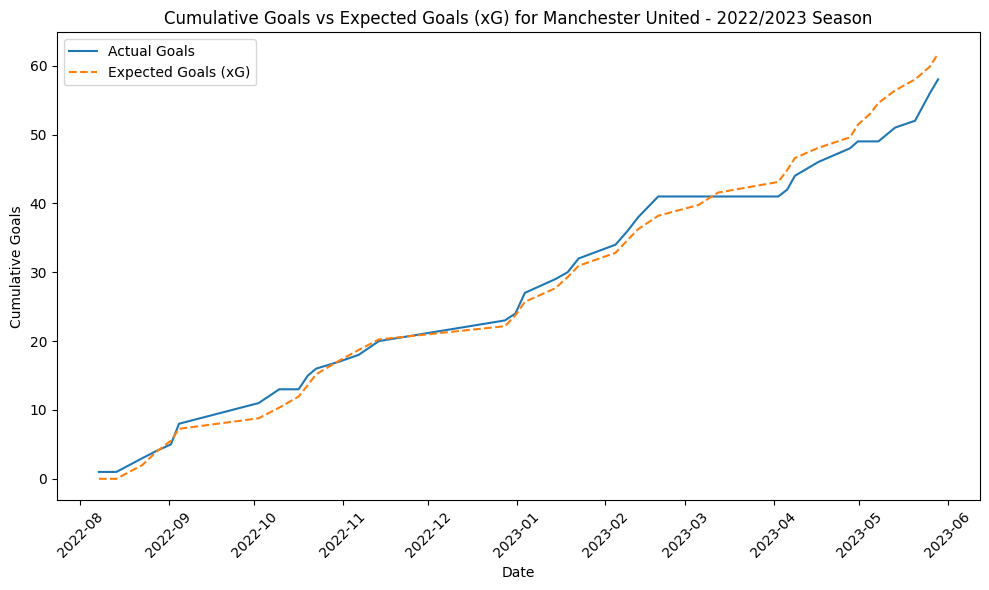

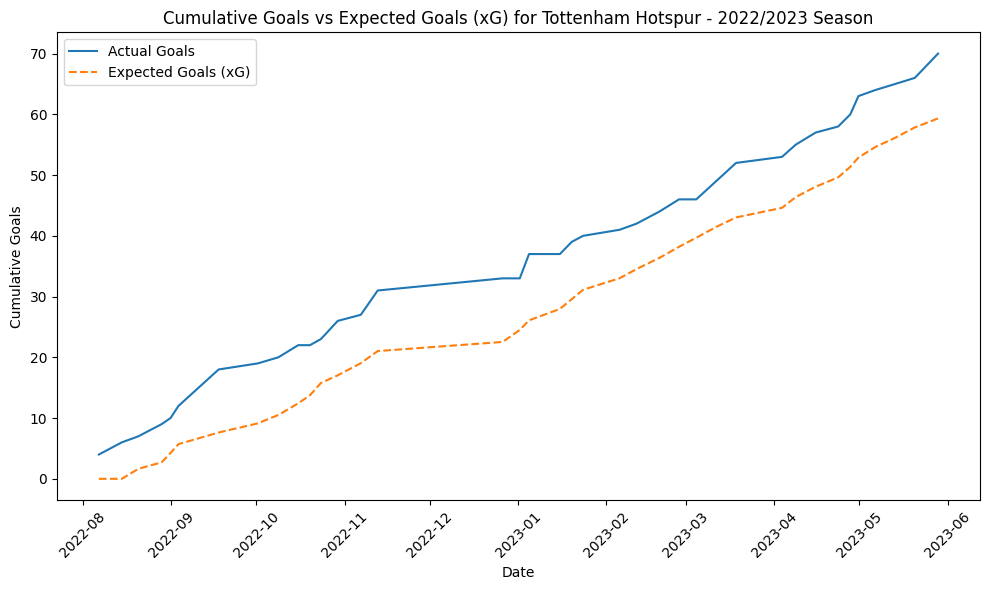

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_past10 = GenerateDataFrame(season=Season.Past10).load()

# Filter data for the season 2023/2024 and the teams Manchester United and Tottenham Hotspur
filtered_df = df_past10[(df_past10['Season'] == '2022/2023') & 
                        (df_past10['HomeTeam'].isin(['Manchester United', 'Tottenham Hotspur']) | 
                         df_past10['AwayTeam'].isin(['Manchester United', 'Tottenham Hotspur']))]

# Create a plot for each team
teams = ['Manchester United', 'Tottenham Hotspur']

for team in teams:
    team_home = filtered_df[filtered_df['HomeTeam'] == team]
    team_away = filtered_df[filtered_df['AwayTeam'] == team]

    # Combine home and away data
    team_df = pd.concat([
        team_home[['Date', 'FTHG', 'PreHXG']].rename(columns={'FTHG': 'Goals', 'PreHXG': 'xG'}),
        team_away[['Date', 'FTAG', 'PreAXG']].rename(columns={'FTAG': 'Goals', 'PreAXG': 'xG'})
    ]).sort_values(by='Date')

    # Cumulative sum for game-by-game analysis
    team_df['CumulativeGoals'] = team_df['Goals'].cumsum()
    team_df['CumulativeXG'] = team_df['xG'].cumsum()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(team_df['Date'], team_df['CumulativeGoals'], label='Actual Goals')
    plt.plot(team_df['Date'], team_df['CumulativeXG'], linestyle='--', label='Expected Goals (xG)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Goals')
    plt.title(f'Cumulative Goals vs Expected Goals (xG) for {team} - 2022/2023 Season')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Feature Engineering

In [3]:
feature_params = {
    Feature.PI_RATINGS.value: True,
    Feature.PI_PAIRWISE.value: True,
    Feature.PI_WEIGHTED.value: True
}

train, test, unique_teams = model.pre_process_data(df_past5)
X_train = XTrainConstructor(train.X, unique_teams, **feature_params).construct_table()

pi_ratings = X_train[['HT', 'AT', 'HT_HomeRating', 'HT_AwayRating', 'AT_HomeRating', 'AT_AwayRating']]
pi_pairwise = X_train[['HT', 'AT', 'PWHT_HomeRating', 'PWHT_AwayRating', 'PWAT_HomeRating', 'PWAT_AwayRating']]
pi_weighted = X_train[['HT', 'AT', 'WPWHT_HomeRating', 'WPWHT_AwayRating', 'WPWAT_HomeRating', 'WPWAT_AwayRating']]
X_train.tail()

,HT,AT,HT_HomeRating,HT_AwayRating,AT_HomeRating,AT_AwayRating,PWHT_HomeRating,PWHT_AwayRating,PWAT_HomeRating,PWAT_AwayRating,WPWHT_HomeRating,WPWHT_AwayRating,WPWAT_HomeRating,WPWAT_AwayRating
1670,Crystal Palace,Liverpool,-0.254519,-0.365293,1.350472,0.824242,-0.502288,0.113153,0.483293,-0.094158,-0.321827,-0.163635,-0.418787,0.606688
1671,Wolverhampton Wanderers,Nottingham Forest,0.107422,-0.368668,-0.185469,-0.609318,0.067026,-0.061662,-0.050932,0.045568,0.056393,-0.163635,-0.418787,-0.307341
1672,Sheffield United,Brentford,-0.900656,-1.214537,0.335671,-0.002683,0.140882,-0.140882,-0.104112,0.104112,-0.450328,-0.163635,-0.418787,-0.001341
1673,Manchester United,AFC Bournemouth,0.502396,0.143777,0.129579,0.034319,0.043740,0.288658,-0.068329,-0.264069,0.417397,-0.163635,-0.418787,-0.149039
1674,Brighton & Hove Albion,Burnley,0.389458,0.313946,-0.652162,-0.505340,-0.081627,-0.109738,0.016453,0.174912,0.099047,-0.156988,0.355644,-0.156988


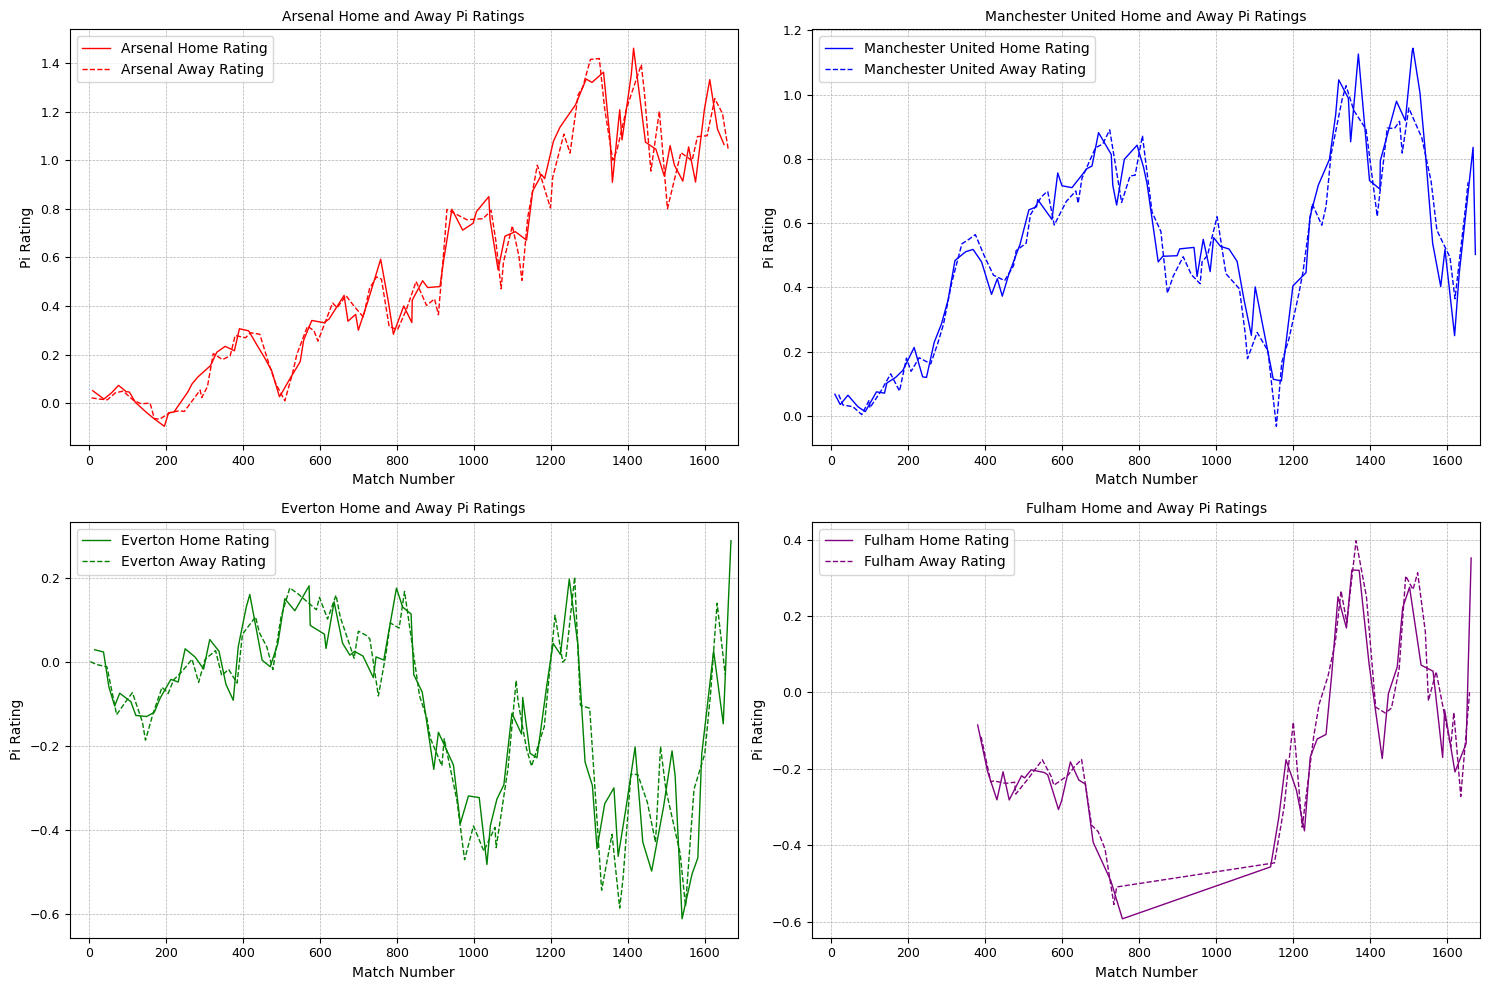

In [4]:
# Plot Pi-ratings
teams = ['Arsenal', 'Manchester United', 'Everton', 'Fulham']
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(15, 10))

for i, team in enumerate(teams):
    team_home = pi_ratings.loc[pi_ratings['HT'] == team]
    team_away = pi_ratings.loc[pi_ratings['AT'] == team]

    # Creating a subplot for each team
    plt.subplot(2, 2, i+1)
    plt.plot(team_home['HT_HomeRating'], label=f'{team} Home Rating', color=colors[i], linewidth=1)
    plt.plot(team_away['AT_HomeRating'], label=f'{team} Away Rating', color=colors[i], linestyle='dashed', linewidth=1)
    
    plt.legend(fontsize='medium')
    plt.title(f'{team} Home and Away Pi Ratings', fontsize=10)
    plt.xlabel('Match Number', fontsize=10)
    plt.ylabel('Pi Rating', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlim(-50, len(df_past5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig('fb_pi_2x2.pdf')
plt.show()

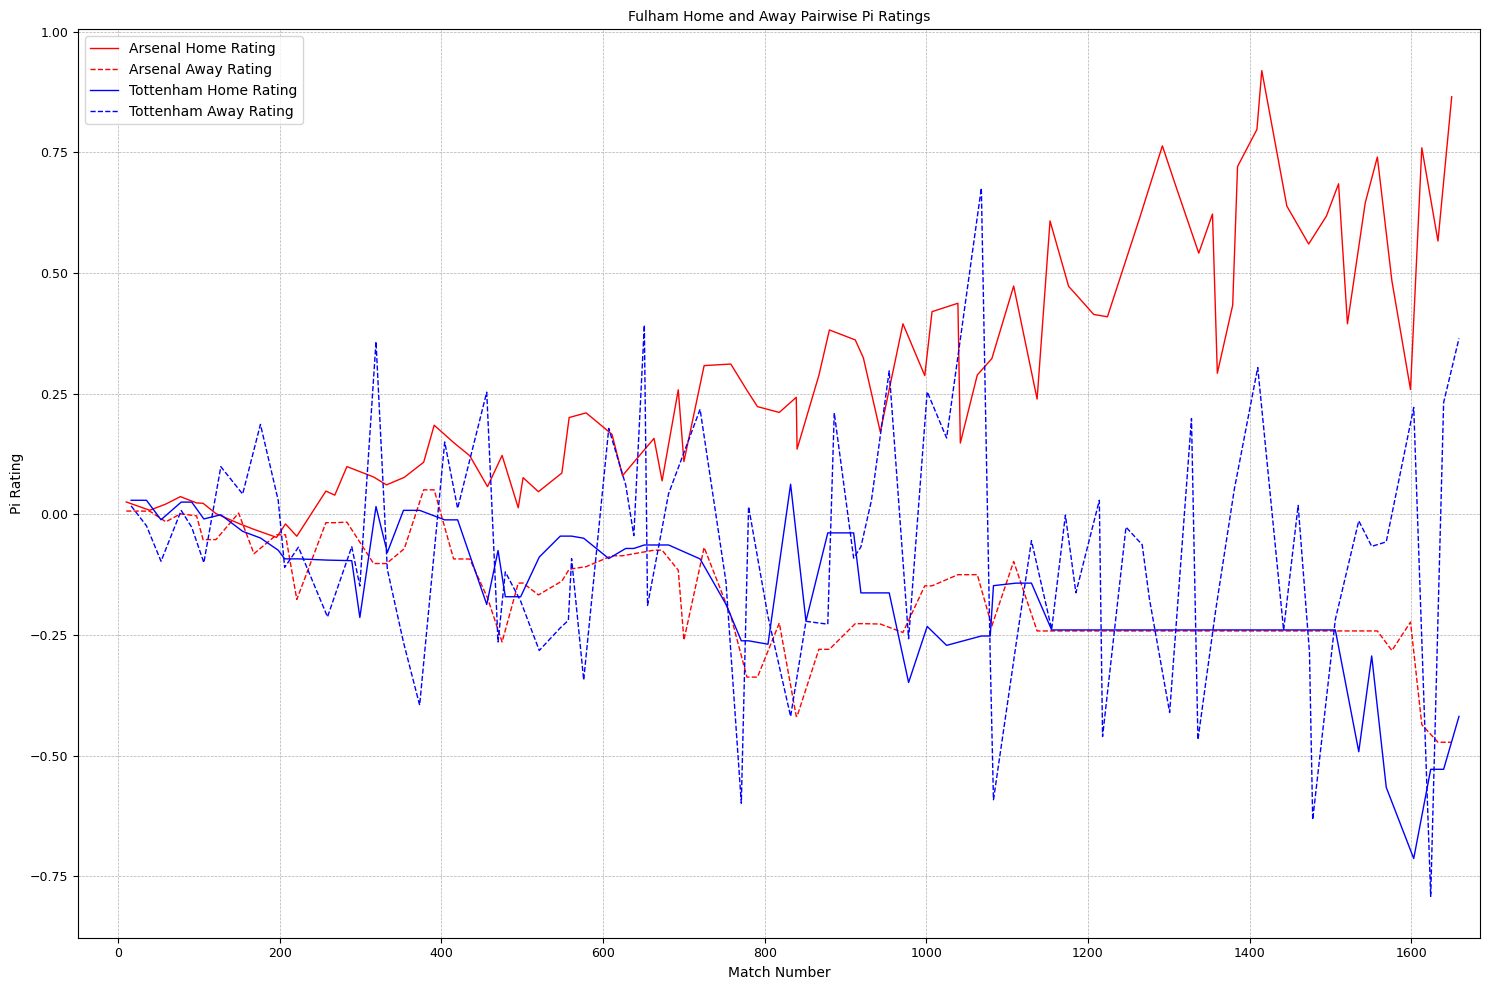

In [14]:
# Plot Pairwise Pi-ratings
plt.figure(figsize=(15, 10))
arsenal = pi_weighted.loc[(pi_weighted['HT'] == 'Arsenal')]
tottenham = pi_weighted.loc[(pi_weighted['HT'] == 'Manchester City')]

plt.plot(arsenal['WPWHT_HomeRating'], label='Arsenal Home Rating', color='red', linewidth=1)
plt.plot(arsenal['WPWHT_AwayRating'], label='Arsenal Away Rating', color='red', linestyle='dashed', linewidth=1)
plt.plot(tottenham['WPWAT_HomeRating'], label='Tottenham Home Rating', color='blue', linewidth=1)
plt.plot(tottenham['WPWAT_AwayRating'], label='Tottenham Away Rating', color='blue', linestyle='dashed', linewidth=1)


plt.legend(fontsize='medium')
plt.title(f'{team} Home and Away Pairwise Pi Ratings', fontsize=10)
plt.xlabel('Match Number', fontsize=10)
plt.ylabel('Pi Rating', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xlim(-50, len(df_past5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('fb_pi_pairwise.pdf')
plt.show()

In [50]:
df_past5.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY',
       'HR', 'AR', 'HP', 'AP', 'B365H', 'B365D', 'B365A', 'PreHXG', 'PreAXG',
       'Status', 'RoundID', 'Season', 'GameWeek'],
      dtype='object')

In [59]:
feature_params = {
    Feature.WIN_STREAK.value: True,
}

train, test, unique_teams = model.pre_process_data(df_past5)
win_streak = XTrainConstructor(train.X, unique_teams, **feature_params).construct_table()
win_streak

,HT,AT,HT_WinStreak,AT_WinStreak
0,Liverpool,Norwich City,1,0
1,West Ham United,Manchester City,0,1
2,AFC Bournemouth,Sheffield United,0,0
3,Burnley,Southampton,1,0
4,Crystal Palace,Everton,0,0
...,...,...,...,...
1595,Crystal Palace,Nottingham Forest,0,0
1596,Brighton & Hove Albion,Liverpool,0,0
1597,West Ham United,Newcastle United,0,0
1598,Wolverhampton Wanderers,Aston Villa,0,0


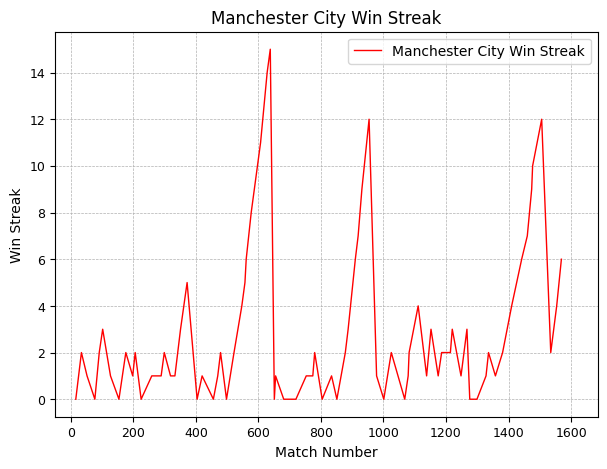

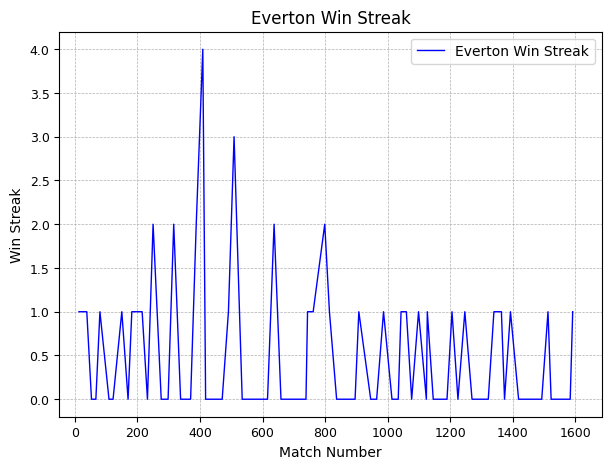

In [48]:

# Define the teams and corresponding colours
teams = ['Manchester City', 'Everton']
colors = ['red', 'blue']

# Loop over each team to create a separate plot for each
for i, team in enumerate(teams):
    team_win_streak = win_streak.loc[(win_streak['HT'] == team)]

    # Create a new figure for each plot
    plt.figure(figsize=(7, 5))
    
    # Plot the win streak for the current team
    plt.plot(team_win_streak['HT_WinStreak'], label=f'{team} Win Streak', color=colors[i], linewidth=1)
    
    # Add title, labels, legend, and grid
    plt.title(f'{team} Win Streak', fontsize=12)
    plt.xlabel('Match Number', fontsize=10)
    plt.ylabel('Win Streak', fontsize=10)
    plt.legend(fontsize='medium')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set axis limits and tick sizes
    plt.xlim(-50, len(df_past5))
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    
    # Save the figure
    plt.savefig(f'{team}_win_streak.pdf')
    
    # Show the plot
    plt.show()


/var/folders/3w/f7q51tgx1zb66cllgwgqhp640000gn/T/ipykernel_29716/555430321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['GoalDifference'] = df_city.apply(
/var/folders/3w/f7q51tgx1zb66cllgwgqhp640000gn/T/ipykernel_29716/555430321.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['Last3'] = df_city['GoalDifference'].shift(1).rolling(window=3).sum()
/var/folders/3w/f7q51tgx1zb66cllgwgqhp640000gn/T/ipykernel_29716/555430321.py:17: SettingWithCopyWarning: 
A value is trying to be set 

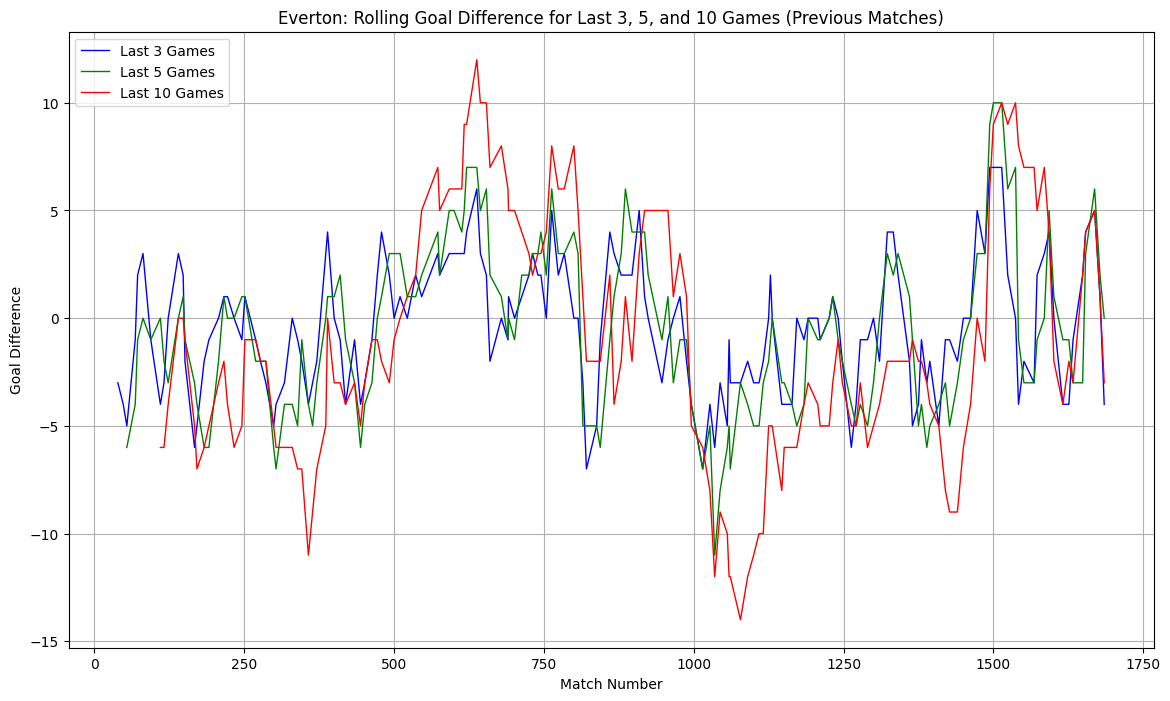

In [79]:
import matplotlib.pyplot as plt

# Calculate Match Number based on the entire dataset
df_past5['MatchNumber'] = range(1, len(df_past5) + 1)

# Filter for Manchester City matches
df_city = df_past5[(df_past5['HomeTeam'] == 'Everton') | (df_past5['AwayTeam'] == 'Everton')]

# Calculate the goal difference for each match
df_city['GoalDifference'] = df_city.apply(
    lambda row: row['FTHG'] - row['FTAG'] if row['HomeTeam'] == 'Manchester City' else row['FTAG'] - row['FTHG'],
    axis=1
)

# Calculate the rolling goal differences for the previous 3, 5, and 10 games
df_city['Last3'] = df_city['GoalDifference'].shift(1).rolling(window=3).sum()
df_city['Last5'] = df_city['GoalDifference'].shift(1).rolling(window=5).sum()
df_city['Last10'] = df_city['GoalDifference'].shift(1).rolling(window=10).sum()

# Use the match numbers from the entire dataset, ensuring continuity with the overall match sequence
df_city['MatchNumber'] = df_city['MatchNumber']

# Plot the rolling goal differences with thinner lines
plt.figure(figsize=(14, 8))

plt.plot(df_city['MatchNumber'], df_city['Last3'], label='Last 3 Games', color='blue', linewidth=1)
plt.plot(df_city['MatchNumber'], df_city['Last5'], label='Last 5 Games', color='green', linewidth=1)
plt.plot(df_city['MatchNumber'], df_city['Last10'], label='Last 10 Games', color='red', linewidth=1)

plt.title('Everton: Rolling Goal Difference for Last 3, 5, and 10 Games (Previous Matches)')
plt.xlabel('Match Number')
plt.ylabel('Goal Difference')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
params = {
    Feature.GOAL_STATS.value: False,
    Feature.SHOOTING_STATS.value: False,
    Feature.POSSESSION_STATS.value: False,
    Feature.RESULT.value: False,
    Feature.ODDS.value: False,
    Feature.XG.value: False,
    Feature.HOME_AWAY_RESULTS.value: False,
    Feature.CONCEDED_STATS.value: False,
    Feature.LAST_N_MATCHES.value: False,
    Feature.WIN_STREAK.value: False,

}

train, test, unique_teams = model.pre_process_data(df_past1)
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, feature_params)

AttributeError: PAIRWISE_STATS

In [30]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm = model.train_model(svm, 'SVM', X_train, y_train, X_test, y_test)

SVM:
[1 0 1 1 1 2 0 0 0 1]
Accuracy: 0.5
F1 Score: 0.3666666666666667
Precision: 0.3833333333333333
Recall: 0.38888888888888884
Cross Validation Accuracy: mean=0.795, std=0.07154

